In [1]:
import numpy as np
from tenpy.networks.mps import MPS
from tenpy.models.hubbard import FermiHubbardModel
from tenpy.algorithms import dmrg

def run_dmrg(L, U, t, mu, chi_max, sweeps):
    model_params = {
        'L': L,
        'U': U,
        't': t,
        'mu': mu,
        'bc_MPS': 'finite',
    }

    model = FermiHubbardModel(model_params)
    # Example change: initializing with an alternating pattern of filled and empty sites
    initial_state = ['empty', 'up'] * (L // 2) if L % 2 == 0 else ['empty', 'up'] * (L // 2) + ['empty']
    psi = MPS.from_product_state(model.lat.mps_sites(), initial_state, bc='finite')

    dmrg_params = {
        'mixer': True,
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-10
        },
        'max_sweeps': sweeps,
    }

    eng = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)
    E0, psi = eng.run()
    return E0


In [4]:
# Example usage:
L = 5  # number of sites
U = 4.0  # on-site interaction strength
t = 1.0*1j + 1.0  # hopping term
mu = 0.0  # chemical potential
chi_max = 200  # max bond dimension
sweeps = 100  # number of DMRG sweeps

E0 = run_dmrg(L, U, t, mu, chi_max, sweeps)
print("Ground State Energy:", E0/L)

Ground State Energy: -0.7727406610312543


In [117]:
from scipy.integrate import quad
from scipy.special import j0, j1
import numpy as np

def integrand(omega, U):
    return j0(omega) * j1(omega) / (omega * (1 + np.exp(2 * U * omega)))

# Define the integral as a function of U
def bethe_ground_state(U):
    result, _ = quad(lambda x: integrand(x, U), 0, np.inf)
    return result*4*(-1)

# Test the function for a specific value of U
bethe_ground_state(U/4)

/var/folders/0g/p234hpyx769d6yprhh69vz040000gn/T/ipykernel_38552/122807654.py:6: RuntimeWarning: overflow encountered in exp
  return j0(omega) * j1(omega) / (omega * (1 + np.exp(2 * U * omega)))


-0.2671549218847479

In [147]:
# Example usage:
U = 4.0  # on-site interaction strength
t = 1.0  # hopping term
mu = 0  # chemical potential
chi_max = 100  # max bond dimension
sweeps = 40  # number of DMRG sweeps

U_list = np.array([0.1, 1, 2, 4, 8])
L_list = np.arange(10, 200, 40)

E0_list = np.zeros(shape=(len(U_list), len(L_list)))

for i, U in enumerate(U_list):
    for j, L in enumerate(L_list):
        E0_list[i, j] = run_dmrg_half_filling(L, U, t, mu, chi_max, sweeps)/L

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=6.91e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.47e-04
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.64e-04
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.76e-04
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=4.18e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=8.69e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.14e-04
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.81e-04
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.62e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=3.55e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=7.13e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=7.83e-05
final DMRG state

C:\Users\Gaurav\AppData\Local\Temp\ipykernel_10036\122807654.py:6: RuntimeWarning: overflow encountered in exp
  return j0(omega) * j1(omega) / (omega * (1 + np.exp(2 * U * omega)))
C:\Users\Gaurav\AppData\Local\Temp\ipykernel_10036\122807654.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(lambda x: integrand(x, U), 0, np.inf)


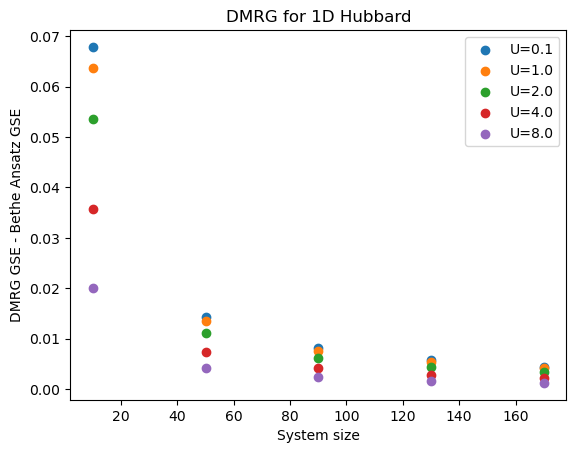

In [153]:
import matplotlib.pyplot as plt

Energy_diff_list = np.zeros_like(E0_list)

for i, U in enumerate(U_list):
    Energy_diff_list[i,:]=E0_list[i, :]-bethe_ground_state(U/4)
    plt.scatter(L_list, E0_list[i, :]-bethe_ground_state(U/4), label='U='+str(U))

plt.title("DMRG for 1D Hubbard")
plt.xlabel("System size")
plt.ylabel("DMRG GSE - Bethe Ansatz GSE")
#plt.yscale('log')
plt.legend()

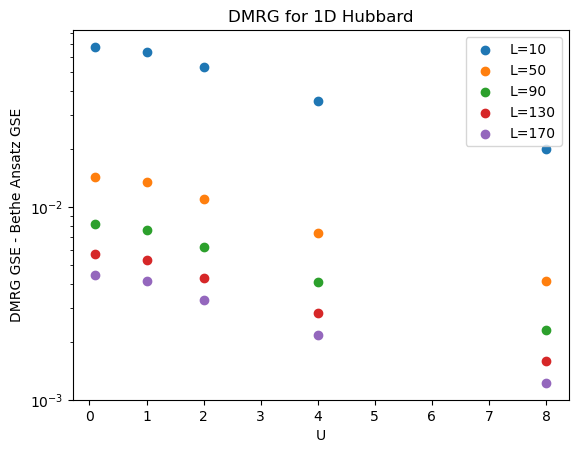

In [161]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("DMRG_deltaE_Hubbard.npy")

U_list = np.array([0.1, 1, 2, 4, 8])
L_list = np.arange(10, 200, 40)

for j, L in enumerate(L_list):
    plt.scatter(U_list, data[:, j], label='L='+str(L))
    
plt.title("DMRG for 1D Hubbard")
plt.xlabel("U")
plt.ylabel("DMRG GSE - Bethe Ansatz GSE")
plt.yscale('log')
plt.legend()

In [159]:
np.save("DMRG_deltaE_Hubbard.npy", Energy_diff_list)

In [396]:
def run_dmrg_half_filling(L, U, t, mu, chi_max, sweeps):
    model_params = {
        'L': L,
        'U': U,
        't':t,
        'mu': mu,
        'bc_MPS': 'finite',
        'bc_x':'periodic',
        'explicit_plus_hc':False
    }

    model = FermiHubbardModel(model_params)

    """
    model.init_lattice(model_params)
    for u1, u2, dx in model.lat.pairs['nearest_neighbors']:
        model.add_coupling(t_star, u1, 'Cdu', u2, 'Cu', dx) 
        model.add_coupling(np.conj(t_star), u2, 'Cu', u1, 'Cdu', -dx)
    
        model.add_coupling(t_star, u1, 'Cdd', u2, 'Cd', dx) 
        model.add_coupling(np.conj(t_star), u2, 'Cd', u1, 'Cdd', -dx)

    model.init_H_from_terms()
    """
    # Initialize the MPS for half-filling with an alternating pattern of up and down spins
    initial_state = ['up', 'down'] * (L // 2) if L % 2 == 0 else ['up', 'down'] * (L // 2) + ['up']
    psi = MPS.from_product_state(model.lat.mps_sites(), initial_state, bc='finite')

    dmrg_params = {
        'mixer': True,  # Enables mixing for better convergence in difficult phases
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-10
        },
        'max_sweeps': sweeps,
    }

    eng = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)
    E0, psi = eng.run()

    return E0




In [329]:
from tenpy.models.hubbard import FermiHubbardModel
import numpy as np

class Complex_Hopping(FermiHubbardModel):
    def __init__(self, model_params, t_star):
        self.t_star = t_star  # Set the complex hopping parameter before initialization
        super().__init__(model_params)  # Initialize the superclass with model_params
        super().init_lattice(model_params)
    
    def init_terms(self, model_params):
        super().init_terms(model_params)  # Call the superclass's init_terms
        # Use the initialized self.t_star for setting up complex hopping terms
        print("Initializing complex hopping terms with t_star =", self.t_star)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            print(f"Adding complex hopping term between site {u1} and site {u2} with displacement {dx}")
            self.add_coupling(self.t_star, u1, 'Cdu', u2, 'Cu', dx) 
            self.add_coupling(np.conj(self.t_star), u2, 'Cu', u1, 'Cdu', -dx)

            self.add_coupling(self.t_star, u1, 'Cdd', u2, 'Cd', dx) 
            self.add_coupling(np.conj(self.t_star), u2, 'Cd', u1, 'Cdd', -dx)

# Example usage of the modified model class
model_params = {
    'L': 4,  # number of lattice sites
    'U': 4.0,  # on-site interaction
    'mu': 0.5,  # chemical potential
    'bc_MPS': 'finite',  # boundary conditions for MPS
    'bc_x': 'periodic'  # boundary condition for the x-directio
}
t_star = np.exp(1j*0.5)  # Complex hopping amplitude

# Create an instance of the custom model
model = Complex_Hopping(model_params, t_star)


Initializing complex hopping terms with t_star = (0.8775825618903728+0.479425538604203j)
Adding complex hopping term between site 0 and site 0 with displacement [1]


In [403]:
# Parameters
L = 10  # Number of lattice sites (ensure it is even for a simple setup)
U = 4.0  # On-site interaction strength
t = np.exp(1j*np.pi*0.1)  # Hopping term
mu = 0  # Chemical potential (often set to 0 for simplicity at half filling)
chi_max = 200  # Maximum bond dimension
sweeps = 100  # Number of DMRG sweeps
t_star = np.exp(1j*np.pi*0.35)
t = t_star


ground_state_energy = run_dmrg_half_filling(L, U, t, mu, chi_max, sweeps)
print("Ground State Energy at Half Filling:", ground_state_energy/L)

Ground State Energy at Half Filling: -0.5802307502085616


In [384]:
model_params = {
    'L': 4,  # number of lattice sites
    'U': 4.0,  # on-site interaction
    'mu': 0.5,  # chemical potential
    't':1j,
    'bc_MPS': 'finite',  # boundary conditions for MPS
    'bc_x': 'periodic'  # boundary condition for the x-directio
}

model = FermiHubbardModel(model_params)

In [190]:
k_num = 30
U = 4.0  # On-site interaction strength
t = 0.0  # Hopping term
mu = U/2  # Chemical potential (often set to 0 for simplicity at half filling)
chi_max = 500  # Maximum bond dimension
sweeps = 500  # Number of DMRG sweeps



norb_list = np.arange(4, 8, 1)

twist_avg_energy = np.zeros(len(norb_list))
std_energy = np.zeros(len(norb_list))
min_energy = np.zeros(len(norb_list))

for ind, norb in enumerate(norb_list):
    energy_arr = np.zeros(k_num)
    for kx in range(-int(k_num/2), int(k_num/2)):
        t_star = np.exp(1j*kx/k_num*np.pi/norb)
        ground_state_energy = run_dmrg_half_filling(norb, U, t_star, t_star, 0, chi_max, sweeps)/norb
        energy_arr[kx+int(k_num/2)] = ground_state_energy

    twist_avg_energy[ind] = energy_arr.mean()
    min_energy[ind] = energy_arr.min()
    std_energy[ind] = run_dmrg_half_filling(norb, U, 1, 0, 0, chi_max, sweeps)/norb

    print(norb)

12


KeyboardInterrupt: 

/var/folders/0g/p234hpyx769d6yprhh69vz040000gn/T/ipykernel_38552/122807654.py:6: RuntimeWarning: overflow encountered in exp
  return j0(omega) * j1(omega) / (omega * (1 + np.exp(2 * U * omega)))


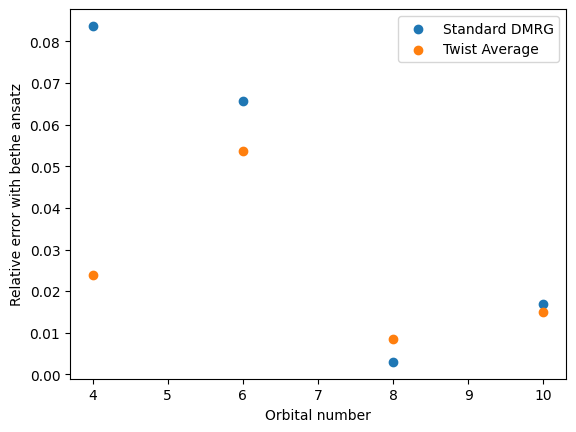

In [189]:
import matplotlib.pyplot as plt

plt.scatter(norb_list, -np.abs(std_energy-bethe_ground_state(U/4))/bethe_ground_state(U/4), label="Standard DMRG")
plt.scatter(norb_list, -np.abs(twist_avg_energy-bethe_ground_state(U/4))/bethe_ground_state(U/4), label="Twist Average")
#plt.scatter(norb_list, min_energy, label="Min over BZ")
#plt.axhline(y=bethe_ground_state(U/4), c='red')
plt.ylabel("Relative error with bethe ansatz")
plt.xlabel("Orbital number")
plt.legend()